In [2]:
import os, sys
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma.core import absolute
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV



## Read Data

In [8]:
df_raw = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [9]:
df_raw.head()

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
0,1292132,Land Rover Range Rover Velar 3.0A Si6 R-Dynami...,land rover,range,"1 owner, no repairs needed! it looks great, in...",2018.0,NaN,08-mar-2018,suv,parf car,...,96000.0,88906.0,132031.0,NaN,NaN,uncategorized,3l supercharged v6 p380 engine at 375bhp/450nm...,"2 x massage/memory/cooling & warmer seat, rear...",NaN,193788.0
1,1294696,Mercedes-Benz C-Class C200 Sport Premium Sunroof,mercedes-benz,c200,rare beautiful white c200 sport premium sunroo...,2017.0,NaN,28-dec-2017,luxury sedan,"parf car, premium ad car",...,85680.0,40678.0,43950.0,NaN,NaN,uncategorized,"2.0l 4 cylinders inline turbocharged engine, p...","multi function steering, electric tailgate, re...",NaN,96800.0
2,1311717,Honda Odyssey 2.4A (COE till 09/2027),honda,odyssey,comes with warranty. full service done.,2007.0,NaN,19-sep-2007,mpv,"coe car, premium ad car, low mileage car",...,138000.0,27994.0,30794.0,NaN,NaN,uncategorized,"2.4l k24a 4 cylinders inline dohc i-vtec, 5 sp...","cruise control, touchscreen audio, reverse cam...",NaN,39800.0
3,1310068,Toyota Corolla Altis 1.6A (COE till 12/2028),toyota,altis,0,2008.0,NaN,15-dec-2008,mid-sized sedan,"coe car, premium ad car",...,160000.0,16084.0,16084.0,NaN,NaN,uncategorized,super fuel efficient 1.6l 16 valves dohc vvt-i...,"leather seats, pioneer dvd audio system with r...",NaN,44800.0
4,1325280,Lexus GS300 (COE till 06/2026),lexus,gs,wear and tear done up. well maintained and reg...,2006.0,NaN,22-dec-2006,luxury sedan,"coe car, premium ad car",...,183000.0,50414.0,55456.0,NaN,NaN,uncategorized,"powerful 3.0l v6 engine, 227bhp, 6 speed , key...",premium upholstery electric seats. memory seat...,NaN,25800.0


In [10]:
df_test.head()

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,dereg_value,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price
0,1303772,Honda Vezel 1.5A X,honda,vezel,4614,2015.0,NaN,29-apr-2015,suv,parf car,...,9582.0,112000.0,19229.0,9229.0,NaN,NaN,uncategorized,"powerful 1.5l i-vtec engine producing 128bhp, ...","pioneer touch screen with reverse camera, 16"" ...",NaN
1,1323166,Mazda 3 1.6A SP (COE till 10/2027),mazda,3,extremely well maintained and in pristine cond...,2007.0,NaN,26-oct-2007,mid-sized sedan,"coe car, premium ad car, low mileage car",...,13644.0,120000.0,14347.0,15782.0,NaN,NaN,uncategorized,fuel efficient 1.6l 4-cylinder inline 16-valve...,"multi-function steering wheel, keyless entry, ...",NaN
2,1308405,MINI Cooper S Countryman 2.0A,mini,cooper,1 owner! beautiful island blue color! eurokars...,2019.0,NaN,27-mar-2020,sports car,parf car,...,54818.0,43000.0,39863.0,47809.0,NaN,NaN,uncategorized,"output of 141kw, 189bhp at 5000rpm to 6000rpm,...","18"" sports rims, sports leather seats, navigat...",NaN
3,1216706,Toyota Vios 1.5A G,toyota,vios,fully agent maintain! genuine low mileage at 5...,2019.0,NaN,28-jun-2019,mid-sized sedan,"parf car, premium ad car",...,26363.0,53300.0,15573.0,15573.0,NaN,NaN,uncategorized,"1.5l 4 cylinder 16 valves dohc vvt-i engine, 7...","push start button, toyota factory player, reve...",NaN
4,1298206,Mazda 3 HB 1.5A,mazda,3,workshop check/sta evaluation available. accid...,2015.0,NaN,19-nov-2015,hatchback,"parf car, premium ad car",...,15197.0,149000.0,18097.0,13097.0,NaN,NaN,uncategorized,1.5l 4 cylinder inline dohc 16 valves skyactiv...,factory fitted audio with audio & multi functi...,NaN


## Data preprocessing

In [11]:
def data_preprocessing(df):
    # Dropping useless cols
    columns_to_drop = ['indicative_price', 'opc_scheme', 'original_reg_date', 'lifespan']
    data_cleaned = df.drop(columns=columns_to_drop)
    
    numerical_columns = ['mileage', 'power', 'road_tax', 'engine_cap', 'depreciation', 'curb_weight', 'dereg_value', 'arf', 'omv']
    data_cleaned[numerical_columns] = data_cleaned[numerical_columns].fillna(data_cleaned[numerical_columns].median())
    
    categorical_columns = ['make', 'fuel_type', 'accessories', 'description', 'features']
    data_cleaned[categorical_columns] = data_cleaned[categorical_columns].fillna(data_cleaned[categorical_columns].mode().iloc[0])

    data_cleaned['manufactured'] = data_cleaned['manufactured'].fillna(data_cleaned['manufactured'].median())
    data_cleaned['no_of_owners'] = data_cleaned['no_of_owners'].fillna(data_cleaned['no_of_owners'].mode()[0])
    
    # Convert 'reg_date' to datetime format and extract year
    data_cleaned['reg_date'] = pd.to_datetime(data_cleaned['reg_date'], format='%d-%b-%Y', errors='coerce')
    data_cleaned['reg_year'] = data_cleaned['reg_date'].dt.year
    
    # Calculate vehicle age by subtracting registration year from current year
    current_year = datetime.now().year
    data_cleaned['vehicle_age'] = current_year - data_cleaned['reg_year']
    
    # Label encoding for categorical features
    categorical_cols = ['make', 'model', 'category', 'type_of_vehicle', 'transmission', 'fuel_type', 'eco_category']
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        data_cleaned[col] = le.fit_transform(data_cleaned[col])
        label_encoders[col] = le  # Save the encoders for future use if needed
    
    data_cleaned['description_length'] = data_cleaned['description'].apply(lambda x: len(str(x).split()))
    data_cleaned['features_length'] = data_cleaned['features'].apply(lambda x: len(str(x).split()))
    data_cleaned['accessories_length'] = data_cleaned['accessories'].apply(lambda x: len(str(x).split()))
    
    columns_to_drop_final = ['listing_id', 'title', 'reg_date', 'description', 'features', 'accessories']
    data_final = data_cleaned.drop(columns=columns_to_drop_final)
    
    return data_final

In [12]:
data_final = data_preprocessing(df_raw)

In [13]:
data_test = data_preprocessing(df_test)


In [14]:
data_final.head()

,make,model,manufactured,type_of_vehicle,category,transmission,curb_weight,power,fuel_type,engine_cap,...,mileage,omv,arf,eco_category,price,reg_year,vehicle_age,description_length,features_length,accessories_length
0,43,595,2018.0,8,119,0,1884.0,280.0,0,2995.0,...,96000.0,88906.0,132031.0,0,193788.0,2018,6,30,21,20
1,51,192,2017.0,2,185,0,1465.0,135.0,0,1991.0,...,85680.0,40678.0,43950.0,0,96800.0,2017,7,61,28,15
2,29,546,2007.0,4,39,0,1648.0,118.0,0,2354.0,...,138000.0,27994.0,30794.0,0,39800.0,2007,17,6,26,12
3,88,156,2008.0,3,36,0,1195.0,80.0,0,1598.0,...,160000.0,16084.0,16084.0,0,44800.0,2008,16,1,25,14
4,44,398,2006.0,2,36,0,1660.0,183.0,0,2995.0,...,183000.0,50414.0,55456.0,0,25800.0,2006,18,50,25,16


In [15]:
data_test.head()

,make,model,manufactured,type_of_vehicle,category,transmission,curb_weight,power,fuel_type,engine_cap,...,dereg_value,mileage,omv,arf,eco_category,reg_year,vehicle_age,description_length,features_length,accessories_length
0,24,620,2015.0,8,90,0,1190.0,96.0,0,1496.0,...,9582.0,112000.0,19229.0,9229.0,0,2015,9,1,21,21
1,42,30,2007.0,3,32,0,1235.0,79.0,0,1598.0,...,13644.0,120000.0,14347.0,15782.0,0,2007,17,47,20,10
2,46,211,2019.0,6,90,0,1535.0,141.0,0,1998.0,...,54818.0,43000.0,39863.0,47809.0,0,2020,4,28,33,14
3,76,622,2019.0,3,141,0,1100.0,79.0,0,1496.0,...,26363.0,53300.0,15573.0,15573.0,0,2019,5,42,25,18
4,42,30,2015.0,1,141,0,1324.0,88.0,0,1496.0,...,15197.0,149000.0,18097.0,13097.0,0,2015,9,28,28,21


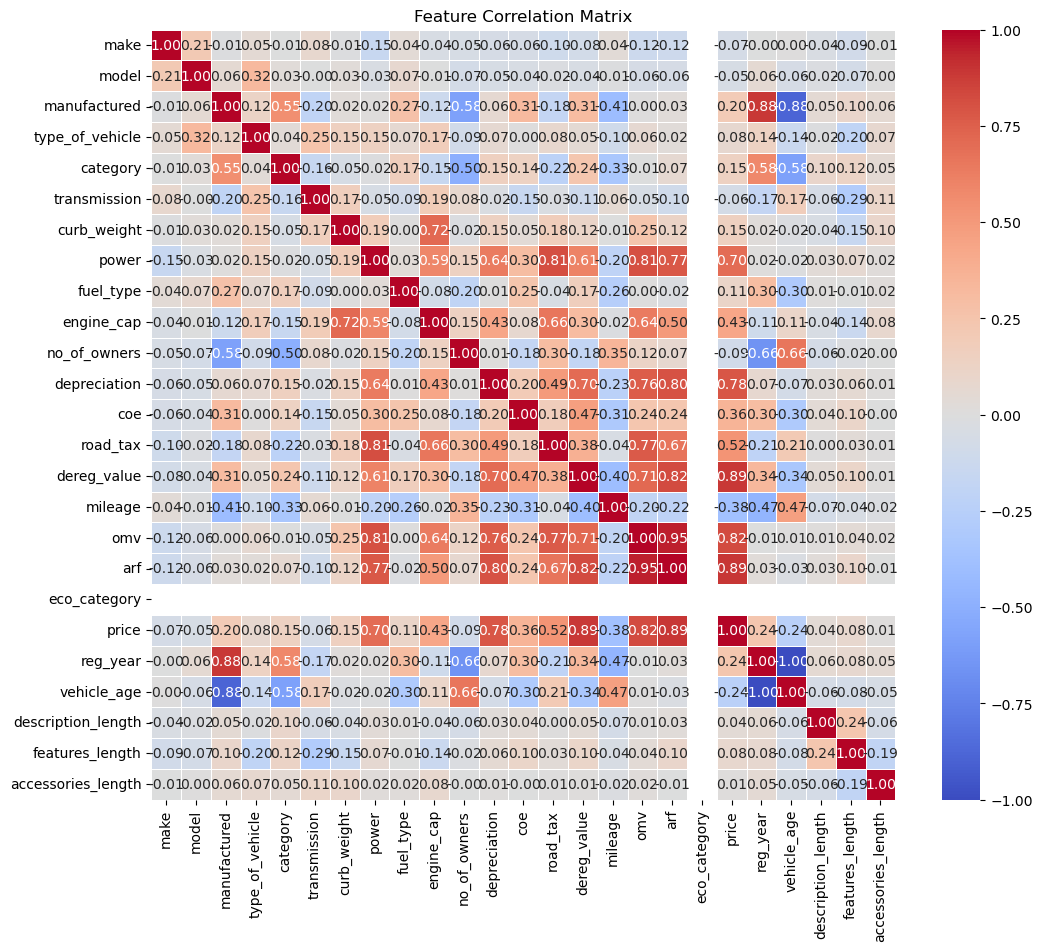

In [16]:
correlation_matrix = data_final.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
X = data_final.drop(columns=['price'])
y = data_final['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model = RandomForestRegressor(**{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}
)
rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

train_mse, test_mse, train_r2, test_r2

In [42]:
"""
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf_model_tune = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model_tune, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params
"""


"\nparam_grid = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [10, 20],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'max_features': ['auto', 'sqrt']\n}\n\nrf_model_tune = RandomForestRegressor(random_state=42)\n\ngrid_search = GridSearchCV(estimator=rf_model_tune, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)\n\ngrid_search.fit(X_train, y_train)\n\nbest_params = grid_search.best_params_\nbest_params\n"

In [15]:
rf_model = RandomForestRegressor(**{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200})

## Evaluation on Random Forest & Linear Regression

In [27]:
mean_absolute_error(y_test, rf_model.predict(X_test))

7196.770516516771

In [51]:
root_mean_squared_error(y_test, rf_model.predict(X_test))

26968.542275870182

In [29]:
r2_score(y_test, rf_model.predict(X_test))

0.9647761520651786

In [87]:
res = rf_model.predict(data_test)

In [44]:
from sklearn.linear_model import LinearRegression

In [45]:
linear_model = LinearRegression()

In [46]:
linear_model.fit(X_train, y_train)

LinearRegression()

In [47]:
mean_absolute_error(y_test, linear_model.predict(X_test))

25600.93388753923

In [50]:
root_mean_squared_error(y_test, linear_model.predict(X_test))

49347.51591551905

In [52]:
r2_score(y_test, linear_model.predict(X_test))

0.8817841134483002

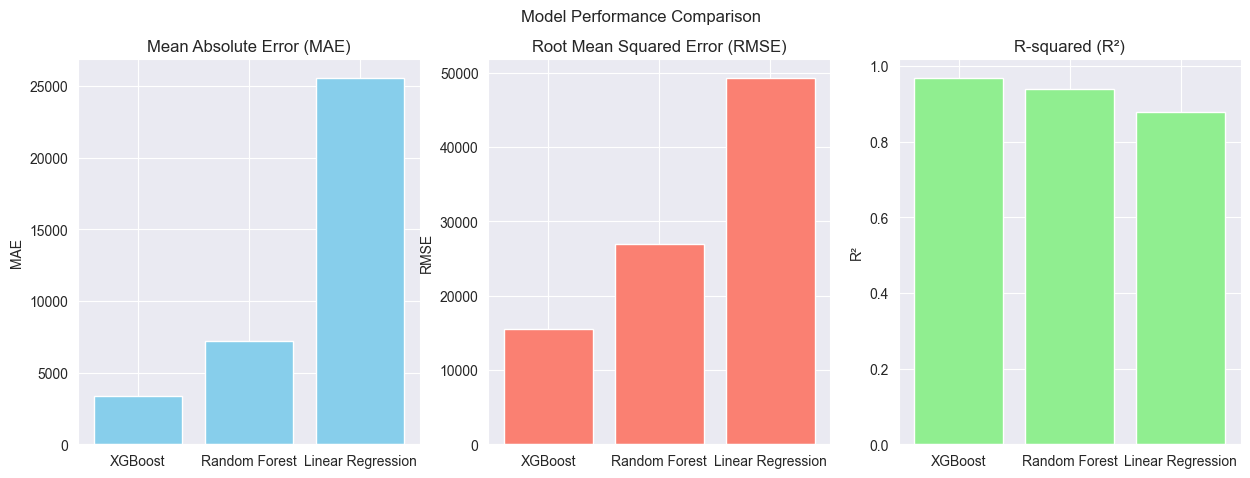

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each model
models = ['XGBoost', 'Random Forest', 'Linear Regression']
mae = [3374.38, 7196.77, 25600.93]
rmse = [15461.67, 26968.54, 49347.51]
r2 = [0.97, 0.94, 0.88]

# Create subplots for each metric
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot MAE
axs[0].bar(models, mae, color='skyblue')
axs[0].set_title('Mean Absolute Error (MAE)')
axs[0].set_ylabel('MAE')

# Plot RMSE
axs[1].bar(models, rmse, color='salmon')
axs[1].set_title('Root Mean Squared Error (RMSE)')
axs[1].set_ylabel('RMSE')

# Plot R-squared
axs[2].bar(models, r2, color='lightgreen')
axs[2].set_title('R-squared (R²)')
axs[2].set_ylabel('R²')

plt.suptitle('Model Performance Comparison')
plt.show()